In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import yfinance as yf

In [44]:
stocks = ['ABG.JO', 'CLs.JO', 'WHL.JO'] # Stock tickers
stock = stocks[-1]
data = yf.download(stock)

[*********************100%%**********************]  1 of 1 completed


In [45]:
stonks = go.Figure(go.Candlestick(x=data.index,
                                   open=data['Open'],
                                   high=data['High'],
                                   low=data['Low'],
                                   close=data['Close'],
                                   
                                   name=f'{stock} Stock Chart'))

stonks.show()

In [46]:
data["Open_L"] = data["Open"].shift(1)
data["High_L"] = data["High"].shift(1)
data["Low_L"] = data["Low"].shift(1)
data["Close_L"] = data["Close"].shift(1)
data["Volume_L"] = data["Volume"].shift(1)

# Drop 'Adj Close' column and NaN columns
data = data.drop("Adj Close", axis=1)
data = data.dropna()

In [47]:
data['Log_Return'] = np.log(data['Close'] / data['Close_L'])

In [48]:
# Dynamic volatility values
n_years = data.index[-1].year - data.index[0].year
inds = [len(data) // i for i in range(1, n_years + 1)]
inds.append(0)
inds.reverse()

In [49]:
vols = []
for i in range(1, n_years + 1):
    vols.append(data.iloc[inds[i - 1]:inds[i]].get('Log_Return').std())

In [50]:
def simulate_stock_prices(S0, T, r, num_simulations, num_steps):
    """
    Simulate stock prices based on geometric Brownian motion.

    Parameters:
    S0 (float): Initial stock price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock
    num_simulations (int): Number of simulations
    num_steps (int): Number of time steps

    Returns:
    ndarray: Array of simulated stock prices
    """
    dt = T / num_steps
    stock_prices = np.zeros((num_simulations, num_steps + 1)).astype('float16')
    stock_prices[:, 0] = S0

    ind = 0
    for i in range(1, num_steps + 1):
        sigma = vols[ind] * 100 # Sigma is multiplied to match amplitude of graph
        if i == inds[ind + 1]:
            ind += 1
            
        Z = np.random.standard_normal(num_simulations)
        stock_prices[:, i] = stock_prices[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    return stock_prices

In [51]:
# Example parameters
S0 = data.iloc[0].get('Close')  # Initial stock price
T = 1  # Time to expiration (in years)
r = 0.05  # Risk-free interest rate
num_simulations = int(320000)  # Number of simulations
num_steps = len(data) - 1  # Number of trading days (days in data)

In [52]:
# Simulate stock prices
simulated_prices = simulate_stock_prices(S0, T, r, num_simulations, num_steps)

# Monte Carlo-based approach
maes = [mean_absolute_error(data.get('Close'), prices) for prices in simulated_prices]
best = maes.index(min(maes))
best_simulated_prices = simulated_prices[best]

/tmp/ipykernel_2304/3057626856.py:27: RuntimeWarning:

overflow encountered in cast



Mean Absolute Error: 745.6318855130348


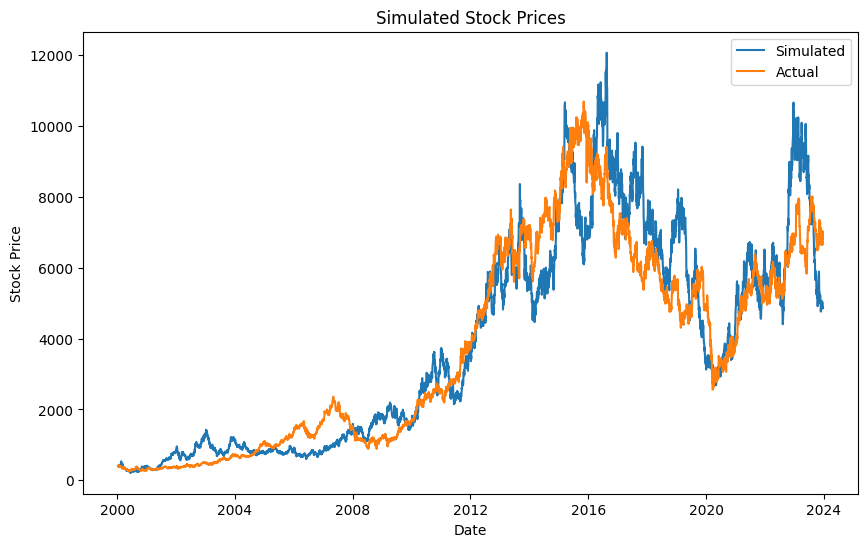

In [53]:
print(f"Mean Absolute Error: {maes[best]}")
# Plot the simulated stock prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, best_simulated_prices.T, label="Simulated")
plt.plot(data.index, data.get('Close'), label='Actual')
plt.title('Simulated Stock Prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()